# Insurance EDA

In [1]:
#Import some libraries
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import plotly.express as px
from pylab import rcParams
import seaborn as sb
sb.set_style('darkgrid')
rcParams['figure.figsize'] = 8,8
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
# from imblearn.over_sampling import SMOTE

pd.options.display.max_rows = 2200

In [2]:
path = "./"

In [3]:
#import data
train = pd.read_csv(path+'/train_data.csv')
test=  pd.read_csv(path+'/test_data.csv')
submission = pd.read_csv(path+'/SampleSubmission.csv')

In [4]:
train.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Building_Type,Date_of_Occupancy,NumberOfWindows,Geo_Code,Claim
0,H14663,2013,1.0,0,N,V,V,U,290.0,1,1960.0,.,1053,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1,1850.0,4,1053,0
2,H3802,2014,1.0,0,N,V,V,U,595.0,1,1960.0,.,1053,0
3,H3834,2013,1.0,0,V,V,V,U,2840.0,1,1960.0,.,1053,0
4,H5053,2014,1.0,0,V,N,O,R,680.0,1,1800.0,3,1053,0


In [5]:
train.shape,test.shape

((7160, 14), (3069, 13))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer Id         7160 non-null   object 
 1   YearOfObservation   7160 non-null   int64  
 2   Insured_Period      7160 non-null   float64
 3   Residential         7160 non-null   int64  
 4   Building_Painted    7160 non-null   object 
 5   Building_Fenced     7160 non-null   object 
 6   Garden              7153 non-null   object 
 7   Settlement          7160 non-null   object 
 8   Building Dimension  7054 non-null   float64
 9   Building_Type       7160 non-null   int64  
 10  Date_of_Occupancy   6652 non-null   float64
 11  NumberOfWindows     7160 non-null   object 
 12  Geo_Code            7058 non-null   object 
 13  Claim               7160 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 783.2+ KB


#### We can see a mixture of object columns and int ones

In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
YearOfObservation,7160.0,2013.669553,1.383769,2012.0,2012.000000,2013.0,2015.00,2016.0
Insured_Period,7160.0,0.909758,0.239756,0.0,0.997268,1.0,1.00,1.0
Residential,7160.0,0.305447,0.460629,0.0,0.000000,0.0,1.00,1.0
Building Dimension,7054.0,1883.727530,2278.157745,1.0,528.000000,1083.0,2289.75,20940.0
Building_Type,7160.0,2.186034,0.940632,1.0,2.000000,2.0,3.00,4.0
Date_of_Occupancy,6652.0,1964.456404,36.002014,1545.0,1960.000000,1970.0,1980.00,2016.0
Claim,7160.0,0.228212,0.419709,0.0,0.000000,0.0,0.00,1.0


#### Not many outliers present, except for Building DImension that the max is so far from 75th percentile

## Missing values

In [8]:
#check for missing values
percent_missing = train.isnull().sum() * 100 / len(train)
missing_value_train = pd.DataFrame({'column_name': train.columns,
                                 'percent_missing': percent_missing})
missing_value_train

,column_name,percent_missing
Customer Id,Customer Id,0.000000
YearOfObservation,YearOfObservation,0.000000
Insured_Period,Insured_Period,0.000000
Residential,Residential,0.000000
Building_Painted,Building_Painted,0.000000
Building_Fenced,Building_Fenced,0.000000
Garden,Garden,0.097765
Settlement,Settlement,0.000000
Building Dimension,Building Dimension,1.480447
Building_Type,Building_Type,0.000000


#### As we can see we have some missing values with majority being in Date_of_Occupancy. Categorical columns don't have missing values except for garden so lets deal with that before continuing exploring. Lets create flags for all missing values and Lets fill the categorical ones  with the mode since there is just a small percentage of missing values

In [9]:
train.isnull().sum()

Customer Id             0
YearOfObservation       0
Insured_Period          0
Residential             0
Building_Painted        0
Building_Fenced         0
Garden                  7
Settlement              0
Building Dimension    106
Building_Type           0
Date_of_Occupancy     508
NumberOfWindows         0
Geo_Code              102
Claim                   0
dtype: int64

In [10]:
train['garden_null'] = train.Garden.isna()
print(train['garden_null'].value_counts())

train['Building Dimension_null'] = train['Building Dimension'].isna()
print(train['Building Dimension_null'].value_counts())

train['Date_of_Occupancy_null'] = train.Date_of_Occupancy.isna()
print(train['Date_of_Occupancy_null'].value_counts())

train['Geo_Code_null'] = train.Geo_Code.isna()
print(train['Geo_Code_null'].value_counts())

False    7153
True        7
Name: garden_null, dtype: int64
False    7054
True      106
Name: Building Dimension_null, dtype: int64
False    6652
True      508
Name: Date_of_Occupancy_null, dtype: int64
False    7058
True      102
Name: Geo_Code_null, dtype: int64


In [11]:
test['garden_null'] = test.Garden.isna()
print(test['garden_null'].value_counts())

test['Building Dimension_null'] = test['Building Dimension'].isna()
print(test['Building Dimension_null'].value_counts())

test['Date_of_Occupancy_null'] = test.Date_of_Occupancy.isna()
print(test['Date_of_Occupancy_null'].value_counts())

test['Geo_Code_null'] = test.Geo_Code.isna()
print(test['Geo_Code_null'].value_counts())

False    3065
True        4
Name: garden_null, dtype: int64
False    3056
True       13
Name: Building Dimension_null, dtype: int64
False    2341
True      728
Name: Date_of_Occupancy_null, dtype: int64
False    3056
True       13
Name: Geo_Code_null, dtype: int64


## Categorical Data
#### Lets dive in into the object columns and int columns that act like categorical columns e.g Date_of_Occupancy, YearOfObservation and building_type

In [12]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

Customer Id                7160
YearOfObservation             5
Insured_Period              401
Residential                   2
Building_Painted              2
Building_Fenced               2
Garden                        3
Settlement                    2
Building Dimension         2044
Building_Type                 4
Date_of_Occupancy           135
NumberOfWindows              11
Geo_Code                   1308
Claim                         2
garden_null                   2
Building Dimension_null       2
Date_of_Occupancy_null        2
Geo_Code_null                 2
dtype: int64

In [13]:
# check unique values in dataset
test.apply(lambda x: len(x.unique()))

Customer Id                3069
YearOfObservation             5
Insured_Period              198
Residential                   2
Building_Painted              2
Building_Fenced               2
Garden                        3
Settlement                    2
Building Dimension          983
Building_Type                 4
Date_of_Occupancy            90
NumberOfWindows              11
Geo_Code                    698
garden_null                   2
Building Dimension_null       2
Date_of_Occupancy_null        2
Geo_Code_null                 2
dtype: int64

#### Unique levels are equal in both test and train or more in train, therefore no issues with missing columns in test present in train

## Levels In the Categorical Data with a lot of classes

In [14]:
train['Date_of_Occupancy'].value_counts()

1960.0    1818
1980.0    1155
1988.0     530
1900.0     371
1970.0     285
1950.0     245
1930.0     167
1920.0     100
1990.0      98
2011.0      97
2009.0      89
2008.0      74
2010.0      65
2012.0      62
2007.0      58
1940.0      53
2000.0      52
1965.0      52
1975.0      52
1850.0      49
2005.0      37
2004.0      35
1985.0      34
1972.0      33
2003.0      33
1978.0      31
1995.0      31
2006.0      31
1910.0      28
2001.0      27
2002.0      27
1974.0      26
1971.0      25
1969.0      24
1800.0      24
1979.0      22
1998.0      22
1955.0      22
1973.0      21
1982.0      21
1989.0      21
1977.0      20
1999.0      20
1983.0      20
1964.0      18
1962.0      18
2013.0      17
1870.0      17
1991.0      17
1890.0      16
1996.0      15
1986.0      15
1992.0      15
1958.0      15
1976.0      15
1954.0      15
1968.0      14
1981.0      14
1967.0      14
1961.0      14
1994.0      14
1959.0      13
1963.0      12
1987.0      12
1984.0      11
1945.0      11
1997.0    

<AxesSubplot:xlabel='Date_of_Occupancy', ylabel='Density'>

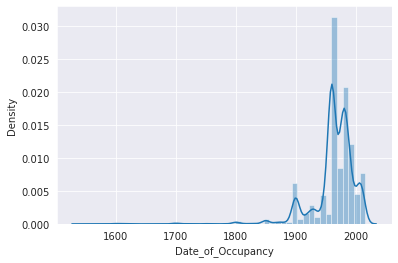

In [15]:
sb.distplot(train['Date_of_Occupancy'])

#### Lets get rid of the tail first because definitely those are not normal(They might be though, maybe they are that old ), so we are going to replace anything before 1900 to 1900 plus we can actually bin this from the description(pre1900,1900-1950 , 1950-2000,2000-Latest year). 
#### But before that lets deal with the missing values first. From the description, we can fill these values with earlier years assuming that they are old enough that they don't even know their First Date of Occupancy instead of mode. So lets fill it with 1900 since we are going to cap years before that to 1900

In [16]:
train['Date_of_Occupancy'] = train['Date_of_Occupancy'].fillna(1900)
test['Date_of_Occupancy'] = test['Date_of_Occupancy'].fillna(1900)



In [17]:
def Occupancy_bins(x):
    if x <= 1900:
        return '<=1900'
    elif x > 1900 and x <=1950:
        return '1901-1950'
    elif x > 1950 and x <=2000:
        return '1951-2000'
    elif x > 41:
        return '2000-2016'#2016 is the max year
train['Occupancy_bins'] = train['Date_of_Occupancy'].apply(Occupancy_bins)
train['Occupancy_bins'].value_counts()

1951-2000    4756
<=1900       1054
1901-1950     679
2000-2016     671
Name: Occupancy_bins, dtype: int64

<AxesSubplot:xlabel='Date_of_Occupancy', ylabel='Density'>

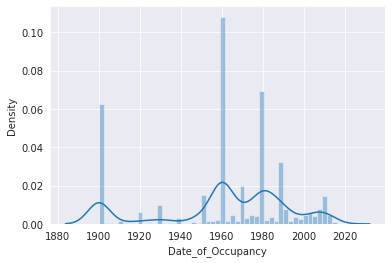

In [18]:
train['Date_of_Occupancy'].loc[train['Date_of_Occupancy'] < 1900]  = 1900
sb.distplot(train['Date_of_Occupancy'])

#### Thats much better

In [19]:
test['Occupancy_bins'] = test['Date_of_Occupancy'].apply(Occupancy_bins)
test['Date_of_Occupancy'].loc[test['Date_of_Occupancy'] < 1900]  = 1900

### Geo Code

In [20]:
train['Geo_Code'].value_counts()

6088     143
33063    137
6083     113
13206     98
31555     87
13205     83
63113     83
21231     76
83137     70
42218     66
92004     61
13001     59
13201     58
34172     57
38185     57
13207     56
75116     52
54395     52
13204     52
64483     49
91174     48
75114     47
67482     46
51454     46
75117     45
64122     45
94068     42
2A004     42
75115     41
14118     41
75118     41
13202     41
34032     39
86194     38
13209     38
30133     38
66136     38
26362     38
92012     37
13208     36
6104      36
6012      36
35288     36
64445     34
59350     33
10387     33
13203     32
62826     28
57463     28
63075     28
92025     27
36044     26
83009     26
87085     26
13004     26
29232     26
75105     24
62108     24
19031     24
76351     23
94067     23
84007     23
83069     23
75120     23
35093     22
44109     22
43157     22
58194     22
92035     22
64102     21
13213     21
68224     21
75109     21
92026     21
34324     21
75112     20
92051     20

#### You can also bin the rare  classes into clustered classes but i am not going to do that. I am going to label encode this 

#### Remember there were missing values here, we are going to fill them with the mode

In [21]:
train['Geo_Code'] = train['Geo_Code'].fillna(train['Geo_Code'].mode()[0])
test['Geo_Code'] = test['Geo_Code'].fillna(test['Geo_Code'].mode()[0])

### Insurance Period

In [22]:
train['Insured_Period'].value_counts()

1.000000    5325
0.997268     547
0.000000     165
0.747945      60
0.495890      49
0.832877      28
0.246575      27
0.997260      26
0.994536      24
0.161644      23
0.915068      23
0.084932      22
0.967213      22
0.665753      21
0.983562      17
0.413699      16
0.580822      16
0.328767      13
0.751366      12
0.748634      12
0.915301      12
0.836066      10
0.579235       9
0.248634       9
0.494536       9
0.502732       8
0.251366       8
0.084699       8
0.163934       7
0.989071       6
0.418033       6
0.415301       6
0.167123       6
0.986301       6
0.334247       6
0.584699       6
0.953425       5
0.252055       5
0.493151       5
0.745205       5
0.581967       5
0.333333       5
0.920765       5
0.821918       5
0.769863       5
0.104110       5
0.893151       5
0.497268       4
0.330601       4
0.038251       4
0.865753       4
0.052055       4
0.164384       4
0.838356       4
0.745902       4
0.657534       4
0.709589       4
0.794521       4
0.120548      

#### We can bin this since 1.0 has a high majority we can map the others as 0

In [23]:
def periodFlag(col):
    if col['Insured_Period'] == 1.000000:
        return 1
    else:
        return 0
    
train['Period_Flag'] = train.apply(periodFlag, axis=1)
test['Period_Flag'] = test.apply(periodFlag, axis=1)

In [24]:
train['Period_Flag'].value_counts()

1    5325
0    1835
Name: Period_Flag, dtype: int64

## Levels In the Categorical Data with less number of classes

V    5382
N    1778
Name: Building_Painted, dtype: int64


Text(0.5, 0, 'Building_Painted')

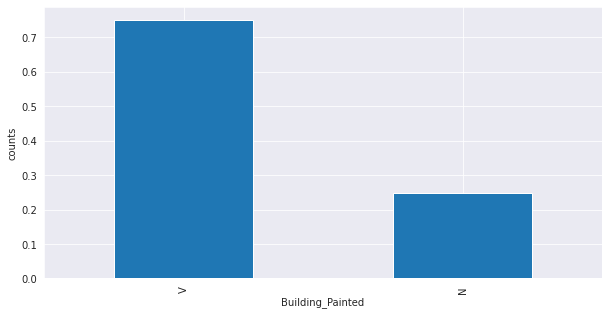

In [25]:
print(train['Building_Painted'].value_counts())
plt.figure(figsize=(10,5))
train['Building_Painted'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Building_Painted')

N    3608
V    3552
Name: Building_Fenced, dtype: int64


Text(0.5, 0, 'Building_Fenced')

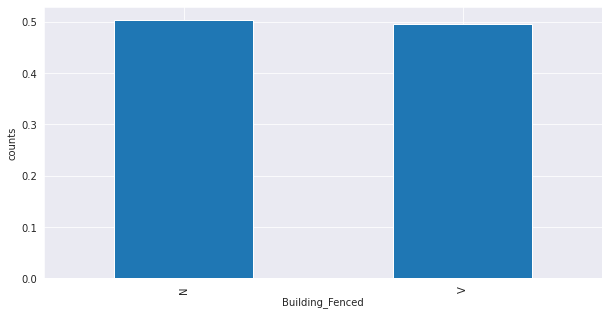

In [26]:
print(train['Building_Fenced'].value_counts())
plt.figure(figsize=(10,5))
train['Building_Fenced'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Building_Fenced')

O    3602
V    3551
Name: Garden, dtype: int64


Text(0.5, 0, 'Garden')

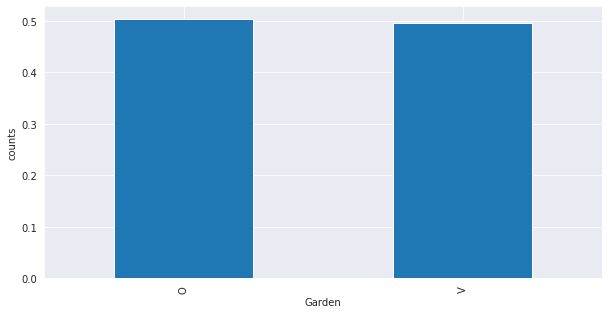

In [27]:
print(train['Garden'].value_counts())
plt.figure(figsize=(10,5))
train['Garden'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Garden')

#### Remember garden had missing values so lets fill them with the mode

In [28]:
train['Garden'] = train['Garden'].fillna(train['Garden'].mode()[0])
test['Garden'] = test['Garden'].fillna(test['Garden'].mode()[0])

R    3610
U    3550
Name: Settlement, dtype: int64


Text(0.5, 0, 'Settlement')

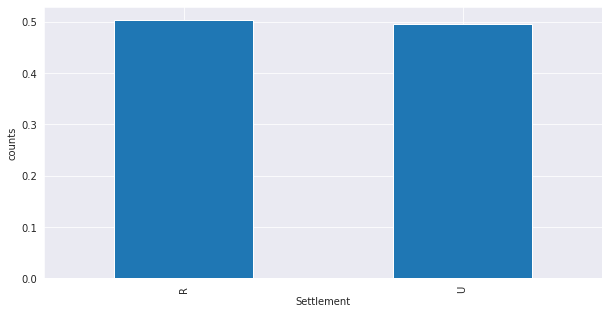

In [29]:
print(train['Settlement'].value_counts())
plt.figure(figsize=(10,5))
train['Settlement'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Settlement')

2    3305
1    1716
3    1230
4     909
Name: Building_Type, dtype: int64


Text(0.5, 0, 'Building_Type')

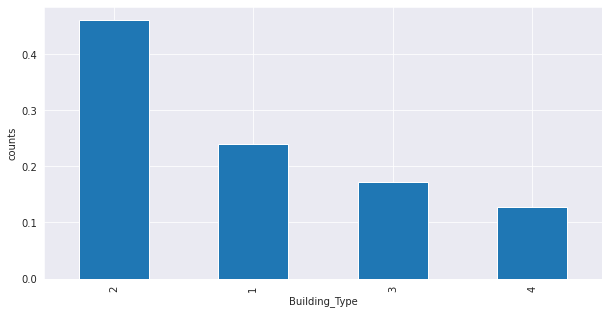

In [30]:
print(train['Building_Type'].value_counts())
plt.figure(figsize=(10,5))
train['Building_Type'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Building_Type')

   .    3551
4        939
3        844
5        639
2        363
6        306
7        211
8        116
1         75
>=10      67
9         49
Name: NumberOfWindows, dtype: int64


Text(0.5, 0, 'NumberOfWindows')

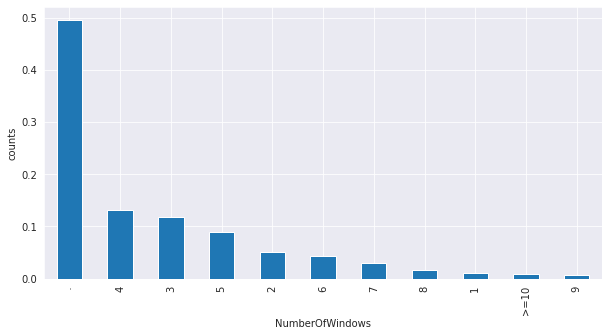

In [31]:

print(train['NumberOfWindows'].value_counts())
plt.figure(figsize=(10,5))
train['NumberOfWindows'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('NumberOfWindows')

### This just has too many levels while one class is overpowering the rest , lets cluster the minority classes

In [32]:
def windows_bins(x):
    majority = ['   .']
    others = ['4','3','5','2','6','7','8','1','>=10','9']

    if x in majority:
        return 'majority'
    elif x in others:
        return 'minority'

train['windows_bins'] = train['NumberOfWindows'].apply(windows_bins)
train['windows_bins'].value_counts()

minority    3609
majority    3551
Name: windows_bins, dtype: int64

In [33]:
test['windows_bins'] = test['NumberOfWindows'].apply(windows_bins)

## Categorical Data vs Target

Text(0.5, 1.0, 'Occupancy_bins  vs Claim')

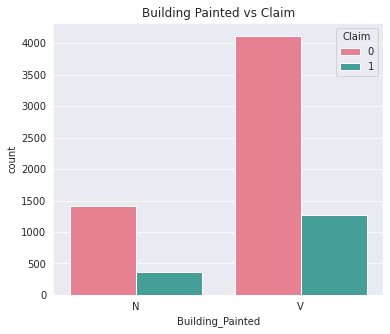

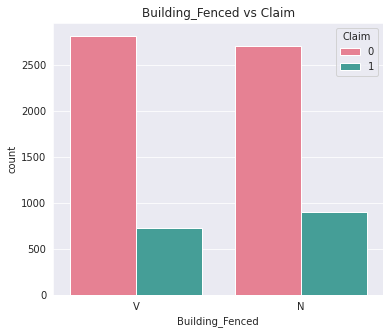

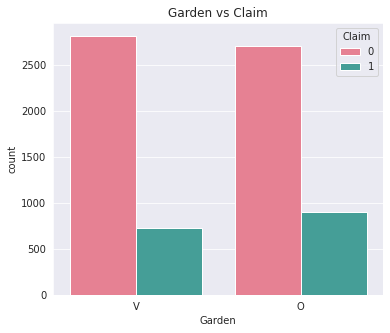

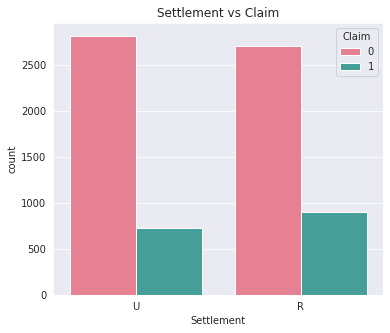

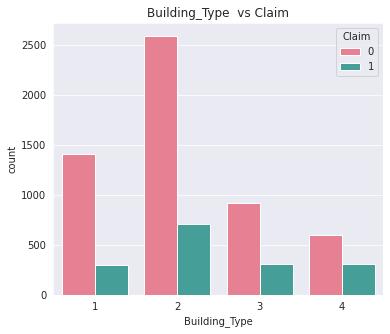

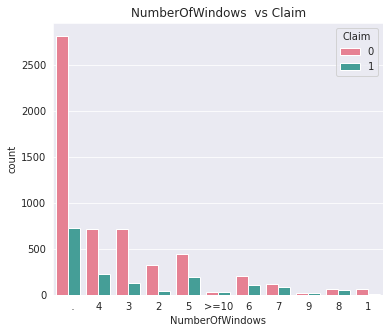

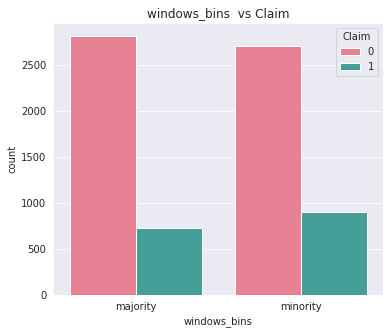

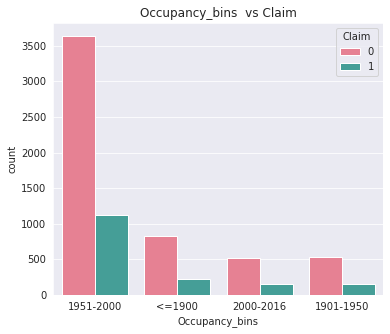

In [34]:
#CATEGORICAL DATA
plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='Building_Painted',hue='Claim',data=train,palette='husl')
plt.title("Building Painted vs Claim")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='Building_Fenced',hue='Claim',data=train,palette='husl')
plt.title("Building_Fenced vs Claim")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='Garden',hue='Claim',data=train,palette='husl')
plt.title("Garden vs Claim")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='Settlement',hue='Claim',data=train,palette='husl')
plt.title("Settlement vs Claim")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='Building_Type',hue='Claim',data=train,palette='husl')
plt.title("Building_Type  vs Claim")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='NumberOfWindows',hue='Claim',data=train,palette='husl')
plt.title("NumberOfWindows  vs Claim")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='windows_bins',hue='Claim',data=train,palette='husl')
plt.title("windows_bins  vs Claim")

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
sb.countplot(x='Occupancy_bins',hue='Claim',data=train,palette='husl')
plt.title("Occupancy_bins  vs Claim")

## Check for Imbalance

0    5526
1    1634
Name: Claim, dtype: int64


Text(0.5, 0, 'Claim')

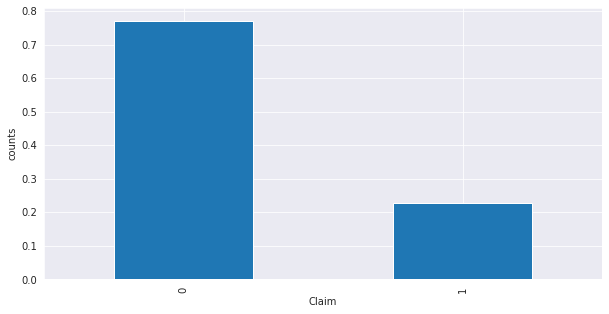

In [35]:
#Check if the predictor class is balanced 
print(train['Claim'].value_counts())
plt.figure(figsize=(10,5))
train['Claim'].value_counts(normalize=True).plot(kind='bar')
plt.ylabel('counts')
plt.xlabel('Claim')

#### A highly imbalanced dataset so be very careful with your cross validation

### Conclusion Categorical Features 
* Most categorical columns have two classes that are almost equal in distribution except for building painted, building type and no of windows which we binned
* They affect the Target equally
* Target is highly imbalanced

## Categorical Features, Feature Engineering

#### Remember Building Dimension had null values so we should fill those, lets fill them by mean because we will need it in groubby functions

In [36]:
train['Building Dimension'] = train['Building Dimension'].fillna(train['Building Dimension'].mean())
test['Building Dimension'] = test['Building Dimension'].fillna(test['Building Dimension'].mean())

In [37]:
#CONCATENATING BOTH THE TEST AND TRAIN FOR EASY DATA MANIPULATON
ntrain = train.shape[0]
ntest = test.shape[0]
data = pd.concat((train, test)).reset_index(drop=True)

### 1. Count Encoding

In [38]:
# check unique values in dataset
train.apply(lambda x: len(x.unique()))

Customer Id                7160
YearOfObservation             5
Insured_Period              401
Residential                   2
Building_Painted              2
Building_Fenced               2
Garden                        2
Settlement                    2
Building Dimension         2044
Building_Type                 4
Date_of_Occupancy           106
NumberOfWindows              11
Geo_Code                   1307
Claim                         2
garden_null                   2
Building Dimension_null       2
Date_of_Occupancy_null        2
Geo_Code_null                 2
Occupancy_bins                4
Period_Flag                   2
windows_bins                  2
dtype: int64

In [39]:
train.shape,test.shape

((7160, 21), (3069, 20))

In [40]:
train.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code', 'Claim', 'garden_null',
       'Building Dimension_null', 'Date_of_Occupancy_null', 'Geo_Code_null',
       'Occupancy_bins', 'Period_Flag', 'windows_bins'],
      dtype='object')

In [41]:
col = ['YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement','Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code','Occupancy_bins','windows_bins','Period_Flag']

## Count of unique features
for i in col:
    data['count_'+i] = data[i].map(data[i].value_counts())

### 2. Frequency Encoding

In [42]:
freq_columns = ['YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement','Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code','Occupancy_bins','windows_bins','Period_Flag']

## Count of unique features
for col in freq_columns:
   data[col+'_freq'] = data[col].map(data[col].value_counts().to_dict())/len(data)

### 3. Groupby mean Encoding and difference

In [43]:
data['gb_feature_YOBSERV_Building Dimension'] = data.groupby(['YearOfObservation'])['Building Dimension'].transform('mean')
data['gb_feature_YOBSERV_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_YOBSERV_Building Dimension']

data['gb_feature_Insured_Period_Building Dimension'] = data.groupby(['Insured_Period'])['Building Dimension'].transform('mean')
data['gb_feature_Insured_Period_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Insured_Period_Building Dimension']

data['gb_feature_Residential_Building Dimension'] = data.groupby(['Residential'])['Building Dimension'].transform('mean')
data['gb_feature_Residential_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Residential_Building Dimension']

data['gb_feature_Building_Painted_Building Dimension'] = data.groupby(['Building_Painted'])['Building Dimension'].transform('mean')
data['gb_feature_Building_Painted_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Building_Painted_Building Dimension']

data['gb_feature_Building_Fenced_Building Dimension'] = data.groupby(['Building_Fenced'])['Building Dimension'].transform('mean')
data['gb_feature_Building_Fenced_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Building_Fenced_Building Dimension']

data['gb_feature_Garden_Building Dimension'] = data.groupby(['Garden'])['Building Dimension'].transform('mean')
data['gb_feature_Garden_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Garden_Building Dimension']

data['gb_feature_Settlement_Building Dimension'] = data.groupby(['Settlement'])['Building Dimension'].transform('mean')
data['gb_feature_Settlement_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Settlement_Building Dimension']

data['gb_feature_Building_Type_Building Dimension'] = data.groupby(['Building_Type'])['Building Dimension'].transform('mean')
data['gb_feature_Building_Type_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Building_Type_Building Dimension']

data['gb_feature_NumberOfWindows_Building Dimension'] = data.groupby(['NumberOfWindows'])['Building Dimension'].transform('mean')
data['gb_feature_NumberOfWindows_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_NumberOfWindows_Building Dimension']

data['gb_feature_Date_of_Occupancy_Building Dimension'] = data.groupby(['Date_of_Occupancy'])['Building Dimension'].transform('mean')
data['gb_feature_Date_of_Occupancy_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Date_of_Occupancy_Building Dimension']

data['gb_feature_Geo_Code_Building Dimension'] = data.groupby(['Geo_Code'])['Building Dimension'].transform('mean')
data['gb_feature_Geo_Code_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Geo_Code_Building Dimension']

data['gb_feature_Occupancy_bins_Building Dimension'] = data.groupby(['Occupancy_bins'])['Building Dimension'].transform('mean')
data['gb_feature_Occupancy_bins_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Occupancy_bins_Building Dimension']

data['gb_feature_windows_bins_Building Dimension'] = data.groupby(['windows_bins'])['Building Dimension'].transform('mean')
data['gb_feature_windows_bins_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_windows_bins_Building Dimension']


data['gb_feature_Period_Flag_Building Dimension'] = data.groupby(['Period_Flag'])['Building Dimension'].transform('mean')
data['gb_feature_Period_Flag_Building Dimension_diff'] = data['Building Dimension'] - data['gb_feature_Period_Flag_Building Dimension']


### 4. Pandas Get Dummies

In [44]:
data = pd.get_dummies(data, columns = ['Building_Type',
       'Occupancy_bins'])
data.head(3)

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Date_of_Occupancy,...,gb_feature_Period_Flag_Building Dimension,gb_feature_Period_Flag_Building Dimension_diff,Building_Type_1,Building_Type_2,Building_Type_3,Building_Type_4,Occupancy_bins_1901-1950,Occupancy_bins_1951-2000,Occupancy_bins_2000-2016,Occupancy_bins_<=1900
0,H14663,2013,1.0,0,N,V,V,U,290.0,1960.0,...,1797.354714,-1507.354714,1,0,0,0,0,1,0,0
1,H2037,2015,1.0,0,V,N,O,R,490.0,1900.0,...,1797.354714,-1307.354714,1,0,0,0,0,0,0,1
2,H3802,2014,1.0,0,N,V,V,U,595.0,1960.0,...,1797.354714,-1202.354714,1,0,0,0,0,1,0,0


### 5. Label Encoding

In [45]:
train.columns

Index(['Customer Id', 'YearOfObservation', 'Insured_Period', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement',
       'Building Dimension', 'Building_Type', 'Date_of_Occupancy',
       'NumberOfWindows', 'Geo_Code', 'Claim', 'garden_null',
       'Building Dimension_null', 'Date_of_Occupancy_null', 'Geo_Code_null',
       'Occupancy_bins', 'Period_Flag', 'windows_bins'],
      dtype='object')

In [46]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le_columns = ['NumberOfWindows', 'Geo_Code','garden_null',
       'Building Dimension_null', 'Date_of_Occupancy_null', 'Geo_Code_null','YearOfObservation', 'Residential',
       'Building_Painted', 'Building_Fenced', 'Garden', 'Settlement','windows_bins']

## Count of unique features
for col in le_columns:
   data[col] = le.fit_transform(data[col])

In [47]:
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Date_of_Occupancy,...,gb_feature_Period_Flag_Building Dimension,gb_feature_Period_Flag_Building Dimension_diff,Building_Type_1,Building_Type_2,Building_Type_3,Building_Type_4,Occupancy_bins_1901-1950,Occupancy_bins_1951-2000,Occupancy_bins_2000-2016,Occupancy_bins_<=1900
0,H14663,1,1.0,0,0,1,1,1,290.0,1960.0,...,1797.354714,-1507.354714,1,0,0,0,0,1,0,0
1,H2037,3,1.0,0,1,0,0,0,490.0,1900.0,...,1797.354714,-1307.354714,1,0,0,0,0,0,0,1
2,H3802,2,1.0,0,0,1,1,1,595.0,1960.0,...,1797.354714,-1202.354714,1,0,0,0,0,1,0,0
3,H3834,1,1.0,0,1,1,1,1,2840.0,1960.0,...,1797.354714,1042.645286,1,0,0,0,0,1,0,0
4,H5053,2,1.0,0,1,0,0,0,680.0,1900.0,...,1797.354714,-1117.354714,1,0,0,0,0,0,0,1


## Continous Features

#### In real sense Building dimension is the only continous feature here, since year is categorical in nature and date of occupation should be changed to datetime format

### Building Dimensions

In [48]:
num_cols = ['Building Dimension']

In [49]:
# for col in train.select_dtypes('float64','int64'):
#     if 'Claim' not in col:
#         plt.figure()
#         sb.displot(train[col])

<AxesSubplot:xlabel='Building Dimension', ylabel='Density'>

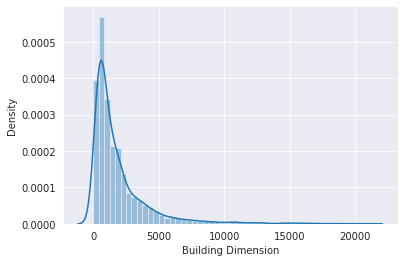

In [50]:
sb.distplot(train['Building Dimension'])

#### Its right skewed so lets try log transform but before lets get some useful info from it 


In [51]:
def add_stats(data, feats):
    
    before_ = data.shape[1]
    cols = feats
    data['f_min']   = data[cols].fillna(0).min(axis = 1)
    data['f_max']   = data[cols].fillna(0).max(axis = 1)
    data['f_mean']  = data[cols].fillna(0).mean(axis = 1)
    data['f_sd']    = data[cols].fillna(0).std(axis = 1)
    data['f_median']= data[cols].fillna(0).median(axis = 1)
    data['f_sum']   = data[cols].fillna(0).sum(axis = 1)
    data['f_skew']  = data[cols].fillna(0).skew(axis=1)

    after_ = data.shape[1]
    new_cols = data.iloc[:,before_:after_].columns.tolist()
    
    return data, new_cols

In [52]:
data, stat_cols = add_stats(data, [col for col in num_cols])


In [53]:
data.head()

,Customer Id,YearOfObservation,Insured_Period,Residential,Building_Painted,Building_Fenced,Garden,Settlement,Building Dimension,Date_of_Occupancy,...,Occupancy_bins_1951-2000,Occupancy_bins_2000-2016,Occupancy_bins_<=1900,f_min,f_max,f_mean,f_sd,f_median,f_sum,f_skew
0,H14663,1,1.0,0,0,1,1,1,290.0,1960.0,...,1,0,0,290.0,290.0,290.0,NaN,290.0,290.0,NaN
1,H2037,3,1.0,0,1,0,0,0,490.0,1900.0,...,0,0,1,490.0,490.0,490.0,NaN,490.0,490.0,NaN
2,H3802,2,1.0,0,0,1,1,1,595.0,1960.0,...,1,0,0,595.0,595.0,595.0,NaN,595.0,595.0,NaN
3,H3834,1,1.0,0,1,1,1,1,2840.0,1960.0,...,1,0,0,2840.0,2840.0,2840.0,NaN,2840.0,2840.0,NaN
4,H5053,2,1.0,0,1,0,0,0,680.0,1900.0,...,0,0,1,680.0,680.0,680.0,NaN,680.0,680.0,NaN


In [56]:
data.drop(['f_sd','f_skew'],axis=1,inplace=True)

In [57]:
data.isnull().sum()

Customer Id                                                0
YearOfObservation                                          0
Insured_Period                                             0
Residential                                                0
Building_Painted                                           0
Building_Fenced                                            0
Garden                                                     0
Settlement                                                 0
Building Dimension                                         0
Date_of_Occupancy                                          0
NumberOfWindows                                            0
Geo_Code                                                   0
Claim                                                   3069
garden_null                                                0
Building Dimension_null                                    0
Date_of_Occupancy_null                                     0
Geo_Code_null           

<AxesSubplot:xlabel='Building Dimension', ylabel='Density'>

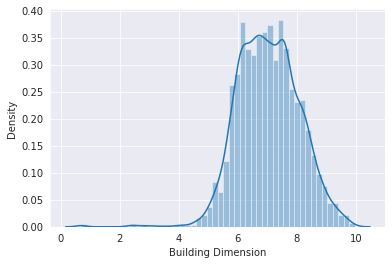

In [58]:
sb.distplot(np.log1p(train['Building Dimension']))

#### Wow looks so much better except now it is slightly left skewed 

In [59]:
data['Building Dimension'] = np.log1p(data['Building Dimension'])


In [60]:
data.isnull().sum()

Customer Id                                                0
YearOfObservation                                          0
Insured_Period                                             0
Residential                                                0
Building_Painted                                           0
Building_Fenced                                            0
Garden                                                     0
Settlement                                                 0
Building Dimension                                         0
Date_of_Occupancy                                          0
NumberOfWindows                                            0
Geo_Code                                                   0
Claim                                                   3069
garden_null                                                0
Building Dimension_null                                    0
Date_of_Occupancy_null                                     0
Geo_Code_null           

## Separate the combined dataset

In [61]:
# Separate train and test data from the combined dataframe
train_df = data[:ntrain]
test_df = data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((7160, 88), (3069, 88))

## Correlation

### 1. Negative correlation with the target

In [62]:
train_df.corr()['Claim'].sort_values()[train_df.corr()['Claim'].sort_values() < 0]

Building_Type_1                             -0.068301
gb_feature_Period_Flag_Building Dimension   -0.065379
Residential_freq                            -0.063509
count_Residential                           -0.063509
count_NumberOfWindows                       -0.061289
NumberOfWindows_freq                        -0.061289
Garden_freq                                 -0.052171
count_windows_bins                          -0.052171
windows_bins_freq                           -0.052171
count_Garden                                -0.052171
Garden                                      -0.052171
count_Settlement                            -0.052019
Settlement_freq                             -0.052019
Settlement                                  -0.052019
Building_Fenced_freq                        -0.051657
Building_Fenced                             -0.051657
count_Building_Fenced                       -0.051657
count_Date_of_Occupancy                     -0.046449
Date_of_Occupancy_freq      

### 2. Positive correlation with the Target

In [63]:
train_df.corr()['Claim'].sort_values()[train_df.corr()['Claim'].sort_values() > 0]

garden_null                                             0.004286
gb_feature_YOBSERV_Building Dimension                   0.008264
count_YearOfObservation                                 0.014497
YearOfObservation_freq                                  0.014497
gb_feature_Occupancy_bins_Building Dimension            0.015606
Date_of_Occupancy                                       0.021929
count_Occupancy_bins                                    0.023462
Occupancy_bins_freq                                     0.023462
Occupancy_bins_1951-2000                                0.024398
Building_Type_3                                         0.026732
gb_feature_Building_Painted_Building Dimension          0.029857
count_Building_Painted                                  0.029857
Building_Painted                                        0.029857
Building_Painted_freq                                   0.029857
Geo_Code_freq                                           0.037285
count_Geo_Code           

## Save the new datasets

In [64]:
train_df.to_csv('new_train.csv',index=False)
test_df.to_csv('new_test.csv',index=False)